# A look at tabular data in Fastai2

- toc: true
- branch: master
- badges: true
- comments: true
- author: Harish Vadlamani
- categories: []

In [1]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [2]:
from data.utils import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai2.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
path = Path('/home/jupyter/datasets/bluebook-for-bulldozers')
Path.BASE_PATH = path
path.ls()

(#15) [Path('Test.csv'),Path('Train.7z'),Path('Valid.zip'),Path('TrainAndValid.7z'),Path('TrainAndValid.zip'),Path('Valid.csv'),Path('Data Dictionary.xlsx'),Path('ValidSolution.csv'),Path('Valid.7z'),Path('Train.zip')...]

---

## Looking at the data

In [4]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


In [5]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [6]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [7]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

Kaggle wants the prediction of our dependant variable based on the RMSLE metric. Hence we'll take the log of it.

In [8]:
dep_var = 'SalePrice'

df[dep_var] = np.log(df[dep_var])

## Handling Dates

A datatype of date by itself is quite useless, si inorder to make it more useful lets get some meta-data related to dates Fastai'a `add_datepart` function. 

In [9]:
df = add_datepart(df, 'saledate')

# Doing the same for our test dataset
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

`add_datepart` replaces every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful.

Let's see all the new columsn added by applying `add_datepart`:

In [10]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

---

## Using TabularPandas and TabularProc

`TabularPandas` is a Fastai class for handling tabular data, which wraps a Pandas data frame and provides a few conveniences. It also splits data into training and validation as required

To populate a `TabularPandas`, we will use two  `TabularProcs`, Categorify and FillMissing. 

- `Categorify` is a TabularProc which replaces a column with a numeric categorical column. 

- `FillMissing` is a TabularProc which replaces missing values with the median of the column, and creates a new boolean column that is set to True for any row where the value was missing.

In [11]:
procs = [Categorify, FillMissing]

In [12]:
# Condition to split training and validation set

cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

`TabularPandas` needs to be told which columns are continuous, and which are categorical. We can handle that automatically using the helper function `cont_cat_split`.

In [13]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [14]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

A `TabularPandas` behaves a lot like a fastai `Datasets` object, including `train` and `valid` attributes.

In [15]:
len(to.train),len(to.valid)

(404710, 7988)

In [16]:
to.show(5)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246.0,999089.0,3157.0,121.0,3.0,2004.0,68.0,2006.0,11.0,46.0,16.0,3.0,320.0,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248.0,117657.0,77.0,121.0,3.0,1996.0,4640.0,2004.0,3.0,13.0,26.0,4.0,86.0,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249.0,434808.0,7009.0,121.0,3.0,2001.0,2838.0,2004.0,2.0,9.0,26.0,3.0,57.0,1.077754e+09,9.210340
3,High,PC120-6E,PC120,#na#,-6E,#na#,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,#na#,EROPS w AC,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139251.0,1026470.0,332.0,121.0,3.0,2001.0,3486.0,2011.0,5.0,20.0,19.0,3.0,139.0,1.305763e+09,10.558414
4,Medium,S175,S175,#na#,#na#,#na#,#na#,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,EROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139253.0,1057373.0,17311.0,121.0,3.0,2007.0,722.0,2009.0,7.0,30.0,23.0,3.0,204.0,1.248307e+09,9.305651


In [17]:
to.items.head(5)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246.0,11.097410,999089.0,3157.0,...,1,1.163635e+09,1,1
1,1139248.0,10.950807,117657.0,77.0,...,1,1.080259e+09,1,1
2,1139249.0,9.210340,434808.0,7009.0,...,1,1.077754e+09,1,1
3,1139251.0,10.558414,1026470.0,332.0,...,1,1.305763e+09,1,1
4,1139253.0,9.305651,1057373.0,17311.0,...,1,1.248307e+09,1,1


All categorical values are also stored as numbers internally na dtheir numbers don't signify anything. Unless you spoecifically specifical that they're ordinal data. Like we did for the column 'ProductSize' initially. 

We can check the order of it as follows:

In [18]:
to.classes['ProductSize']

(#7) ['#na#','Large','Large / Medium','Medium','Small','Mini','Compact']

Let's save this TabularPandas isnatnce as it does take some time to get it loaded. 

In [19]:
(path/'to.pkl').save(to)

In [20]:
# Loading again

# to = (path/'to.pkl').load()

---

## Decision Trees

In [21]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [22]:
dt = DecisionTreeRegressor(max_leaf_nodes=4)
dt.fit(xs, y);

In [37]:
dt = DecisionTreeRegressor(min_samples_leaf=25)
dt.fit(xs, y);

In [23]:
# draw_tree(dt, xs, size=7, leaves_parallel=True, precision=2)

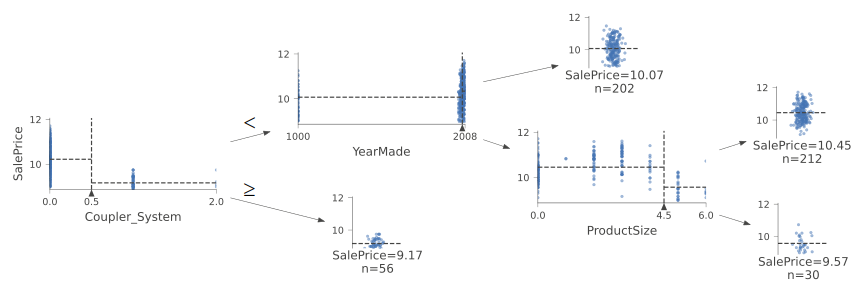

In [24]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(dt, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [38]:
dt.get_n_leaves()

12397

### Model Inference

#### r2 score

In [39]:
train_score = dt.score(valid_xs, valid_y)
train_score

0.8615874485325126

In [40]:
y_predict = dt.predict(valid_xs)

In [41]:
from sklearn.metrics import r2_score

r2_score(valid_y, y_predict)

0.8615874485325126

We can see that the model score is nothing but the r2 score. But r2 score isn't a great metric to check the performance of the model. 

#### MSE and RMSE

In [54]:
# Manual definition

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [42]:
# Using in-built sklearn methods for mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(valid_y, y_predict)
mse

0.07272285105538953

In [43]:
rmse = np.sqrt(mse)
rmse

0.26967174686160494

#### Cross-Validation

In [32]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=dt,
                         X=xs,
                         y=y,
                         cv=3,
                         n_jobs=1, scoring='neg_mean_squared_error')

print(f'CV Negative MSE scores: {scores}')
print('CV  Negative MSE: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV Negative MSE scores: [-0.34616215 -0.28641598 -0.34540964]
CV  Negative MSE: -0.326 +/- 0.028


---

## Random Forests

- Random forests: Weak Decision trees(with reasonable depth) + Bootstrapping(row sampling) + column sampling + aggregation

In [84]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [45]:
# Fitting the model
m = rf(xs, y)

In [46]:
mse = mean_squared_error(valid_y, y_predict)
mse

0.07272285105538953

In [47]:
rmse = np.sqrt(mse)
rmse

0.26967174686160494

In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=m,
                         X=xs,
                         y=y,
                         cv=5,
                         n_jobs=1, scoring='neg_mean_squared_error')

print(f'CV Negative MSE scores: {scores}')
print('CV  Negative MSE: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV Negative MSE scores: [-0.07892926 -0.06547282 -0.07954379 -0.07532152 -0.07963863]
CV  Negative MSE: -0.076 +/- 0.005


### Impact of number of trees to RMSE:

In [52]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

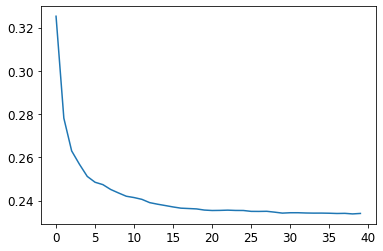

In [55]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Validation using out-of-bag error

In [56]:
r_mse(m.oob_prediction_, y)

0.210875

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

### Tree variance and prediction confidence

In [57]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

preds.shape

(40, 7988)

Now we have a prediction for every tree and every auction, for 160 trees and 7988 auctions in the validation set.

Using this we can get the standard deviation of the predictions over all the trees, for each auction:

In [58]:
preds_std = preds.std(0)

In [59]:
preds_std[:5]

array([0.28703584, 0.09510641, 0.10112014, 0.2649524 , 0.1027509 ])

As you can see, the confidence of the predictions varies widely. For some auctions, there is a low standard deviation because the trees agree. For others, it's higher, as the trees don't agree. This is information that would be useful to use in a production setting; for instance, if you were using this model to decide what items to bid on at auction, a low-confidence prediction may cause you to look more carefully into an item before you made a bid.

### Feature Importance

- Feature importance gives a very good idea of how the model is making predictions and based on which feature in your dataset. 

In [60]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [62]:
fi = rf_feat_importance(m, xs)

fi.head(10)

,cols,imp
57,YearMade,0.177433
6,ProductSize,0.119214
30,Coupler_System,0.115540
7,fiProductClassDesc,0.075936
54,ModelID,0.056715
65,saleElapsed,0.050846
31,Grouser_Tracks,0.048119
3,fiSecondaryDesc,0.042587
32,Hydraulics_Flow,0.040498
1,fiModelDesc,0.034652


Let's plot this:

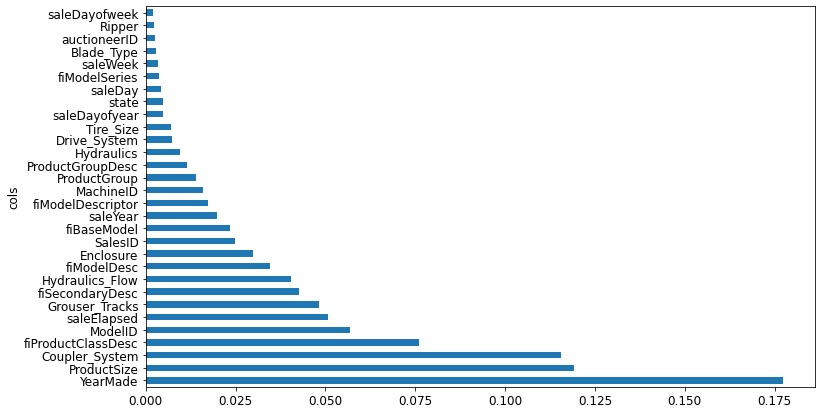

In [63]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is added across all branches of all trees, and finally the scores are normalized such that they add to 1.0.

### Removing low-importance variables

In [64]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [65]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [66]:
m = rf(xs_imp, y)

In [67]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.18147, 0.232558)

We can clearly see that by reducing unimportant models, it improves out model performance, albeit slightly. More importantly we have lesser comulns to deal with.  

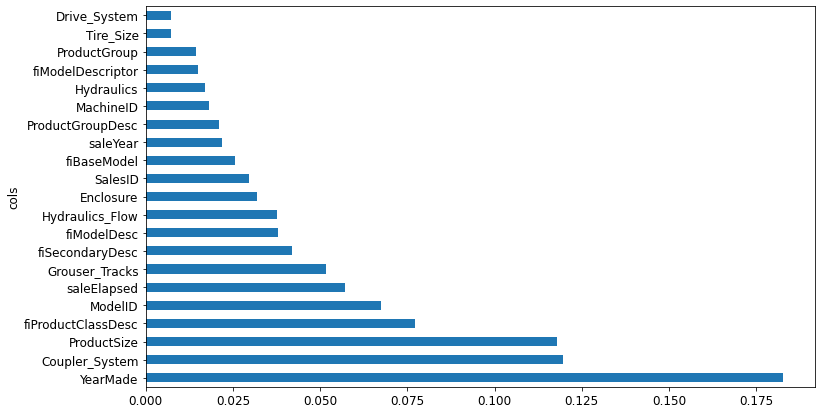

In [68]:
plot_fi(rf_feat_importance(m, xs_imp));

### Removing redundant features

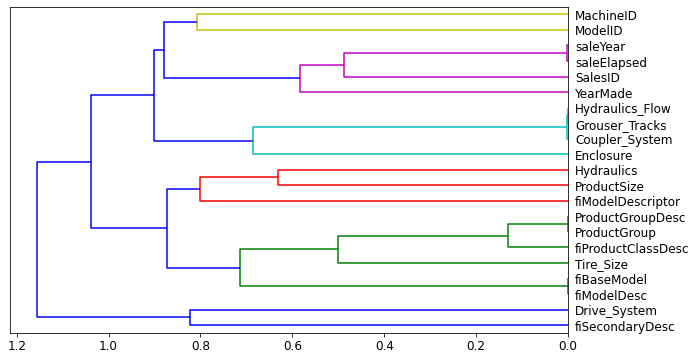

In [69]:
cluster_columns(xs_imp)

> ***Note:*** The most similar pairs are found by calculating the rank correlation, which means that all the values are replaced with their rank (i.e. first, second, third, etc within the column), and then the correlation is calculated.

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower max_samples and higher min_samples_leaf . The score is a number returned by sklearn that is 1.0 for a perfect model, and 0.0 for a random model. (In statistics it's called R^2, although the details aren't important for this explanation). We don't need it to be very accurate--we're just going to use it to compare different models, based on removing some of the possibly redundant columns.

In [70]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [71]:
get_oob(xs_imp)

0.8770483388547817

In [72]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8771490334152763,
 'saleElapsed': 0.872478570192096,
 'ProductGroupDesc': 0.8771907049228934,
 'ProductGroup': 0.8773011454458872,
 'fiModelDesc': 0.8768482857357454,
 'fiBaseModel': 0.8762699628950377,
 'Hydraulics_Flow': 0.8772973002834209,
 'Grouser_Tracks': 0.8773588346127403,
 'Coupler_System': 0.8785444917027587}

In [73]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8741877433999191

---

### Using sklearns rfecv for feature elemination

In [79]:
# import operator
# from sklearn.feature_selection import RFECV
# rf = RandomForestRegressor()
# feature_names = xs.columns

# rfecv = RFECV(
#     estimator=rf,
#     step=1,
#   scoring='neg_mean_squared_error'
# )
# rfecv.fit(xs, y)

# plt.figure()
# plt.title('RFE with Random Forest Regressor')
# plt.xlabel('Number of selected features')
# plt.ylabel('10-fold Crossvalidation')

# # grid_scores_ returns a list of accuracy scores
# # for each of the features selected
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

# plt.show()

# print('rfecv.grid_scores_: {grid_scores}'.format(grid_scores=rfecv.grid_scores_))

# # support_ is another attribute to find out the features
# # which contribute the most to predicting
# new_features = list(filter(
#     lambda x: x[1],
#     zip(feature_names, rfecv.support_)
# ))

# print('rfecv.support_: {support}'.format(support=rfecv.support_))

# # Features are the most suitable for predicting the response class
# new_features = list(map(operator.itemgetter(0), new_features))
# print('\nThe most suitable features for prediction: {new_features}'.format(new_features=new_features))

---

In [80]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [81]:
(path/'xs_final.pkl').save(xs_final)
(path/'valid_xs_final.pkl').save(valid_xs_final)

In [82]:
xs_final = (path/'xs_final.pkl').load()
valid_xs_final = (path/'valid_xs_final.pkl').load()

In [85]:
# verification, sanity check

m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183335, 0.235938)

### Partial Dependance:

### Data Leakage:

### Tree Interpreter

### Extrapolation problem in RF

### Finding out of domain data
> Using a RF

---


## Using a Neural Network

In [86]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

Using RF's feature importance method gives us a good start for data to consider using a NN

In [88]:
df_nn_final = df_nn[list(xs_final.columns) + [dep_var]]